In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:


from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB




In [3]:
# Basic preprocessing
def preprocess(df):
    df_new = df.copy()
    
    # Discard identifiers, style information, timestamps
    df_new = df_new[df_new.columns.difference(['image', 'style', 'reviewTime', 
                                               'reviewerID', 'asin', 'reviewerName', 'unixReviewTime'])]

    # Turn category into binary features
    for cat in df_new.category.unique():
        df_new[cat] = df_new['category'] == cat

    # Drop category column
    df_new.drop(columns=['category'], inplace=True)

    # NaN vote is 0 users found helpful
    df_new.vote.fillna(0, inplace=True)
    
    # Turn vote into binary feature
    df_new.vote = df_new.vote > 0
    # df_new.vote.clip(0, 10)
    # df_new.vote = df_new.vote / 10

    # NaN summary is empty summary
    df_new.summary.fillna('', inplace=True)

    # Turn Booleans into binary variables
    df_new.replace({False: 0, True: 1}, inplace=True)
    
    return df_new

In [4]:
# Remove 'overall' column and add cutoff column applying cutoff
def apply_cutoff(df, cutoff):
    df_new = df.copy()
    
    # Apply cutoff
    cut = df['overall'] > cutoff
    df_new['cutoff'] = cut

    # Drop overall and category
    df_new.drop(columns=['overall'], inplace=True)
    
    # Turn Booleans into binary variables
    df_new.replace({False: 0, True: 1}, inplace=True)
    
    return df_new

In [5]:
def apply_tfidf(df, review_vectorizer, summary_vectorizer):
    review_matrix = pd.DataFrame(data=review_vectorizer.transform(df.reviewText).toarray(), columns='R_' + review_vectorizer.get_feature_names_out())
    summary_matrix = pd.DataFrame(data=summary_vectorizer.transform(df.summary).toarray(), columns='S_' + summary_vectorizer.get_feature_names_out())
    df_new = pd.concat([df, review_matrix, summary_matrix], axis=1)
    df_new.drop(columns=['summary', 'reviewText'], inplace=True)
    return df_new

In [6]:
training_df = pd.read_csv('../data/Training.csv')
test_df = pd.read_csv('../data/Test.csv')

# Processing the data - I

In [7]:
# Preprocessing of training data
proc_training_df = apply_cutoff(preprocess(training_df), 1)

# Set cutoff to be the label; define X and y accordingly
X = proc_training_df.drop('cutoff', axis=1)
y = proc_training_df['cutoff']

# Fit TF-IDF vectorizer for 'reviewText' and 'summary' features, creating max. 11500 features.
r_vectorizer = TfidfVectorizer(max_features=11500, stop_words='english', ngram_range=(1, 3))
s_vectorizer = TfidfVectorizer(max_features=11500, stop_words='english', ngram_range=(1, 3))
r_vectorizer.fit(X.reviewText)
s_vectorizer.fit(X.summary)

# Apply TF-IDF vectorization 
X = apply_tfidf(X, r_vectorizer, s_vectorizer)

# Apply robust scaling
scaler = preprocessing.RobustScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

In [8]:
X

,verified,vote,automotive,CDs,grocery,cell_phones,sports,toys,R_00,R_000,...,S_zest,S_zest far,S_zest far inferior,S_zimmer,S_zipper,S_zippers,S_zoom,S_zz,S_zz greatest,S_zz greatest hits
0,-1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# Let us reduce the number of features by eliminating the statistically least correlated ones.
relcols = X.columns[abs(X.corrwith(y)) > 0.01]
relcols

Index(['verified', 'vote', 'R_00', 'R_08', 'R_10 bucks', 'R_12', 'R_15',
       'R_1970', 'R_1970s', 'R_1973',
       ...
       'S_wtf', 'S_year old', 'S_young', 'S_yuck', 'S_yucky', 'S_yuk', 'S_yum',
       'S_yummy', 'S_zero', 'S_zero stars'],
      dtype='object', length=4272)

In [10]:
# We will go with these columns.
X = X[relcols]

In [11]:
# 5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
splits = []
for train_idx, val_idx in kf.split(X, y):
    # Apply split
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Reset indices
    X_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    X_val.reset_index(drop=True, inplace=True)
    y_val.reset_index(drop=True, inplace=True)
    splits.append((X_train, X_val, y_train, y_val))
f1_scores, acc_scores, roc_auc_scores, conf_matrices, models = [], [], [], [], []

## Logistic Regression

In [12]:
# Hyperparameter selection on one split
# import sys
# sys.path.append("..")

import sys
sys.path.append("..")

from mechanism.mechanized_models import Mechanism
from sklearn import preprocessing

from mechanism.mechanized_models import MechanizedGridSearchCV


from mechanism.mechanized_models import MechanizedLogisticRegression

X_train, X_val, y_train, y_val = splits[0]


gs_cls = MechanizedLogisticRegression(max_iter=1500)
gs_cls.choose_mechanism(Mechanism.GAUSSIAN)

params_LR = {'C': np.logspace(0.7, 1.1, num=1)}
gs_LR = MechanizedGridSearchCV(estimator=gs_cls, param_grid=params_LR, cv=2, verbose=2, scoring='f1_macro')
gs_LR.choose_mechanism(Mechanism.GAUSSIAN)

gs_LR.fit(X_train, y_train)
gs_LR.best_params_

in gaussian mechanism GridSearchCV
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] END ................................C=5.011872336272722; total time=   7.5s
[CV] END ................................C=5.011872336272722; total time=   8.7s


{'C': 5.011872336272722}

In [13]:
# Let us now compute performance metrics.
for i, (X_train, X_val, y_train, y_val) in enumerate(splits[0:1]):
    print(f"Split {i}:")
    # Train model

    
    # model = LogisticRegression(max_iter=1500, C=gs_LR.best_params_['C'])
    model = MechanizedLogisticRegression(max_iter=1500, C=gs_LR.best_params_['C'])
    model.choose_mechanism(Mechanism.GAUSSIAN)

    
    model.fit(X_train, y_train)
    # Predict
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)
    # Compute and append f1, accuracy, confusion matrix; 
    f1_scores.append(f1_score(y_val, y_pred, average='macro'))
    acc_scores.append(accuracy_score(y_val, y_pred))
    roc_auc_scores.append(roc_auc_score(y_val, y_proba[:, 1]))
    print(f"  F1 score: {f1_scores[-1]}")
    print(f"  Accuracy: {acc_scores[-1]}")
    print(f"  ROC/AUC score: {roc_auc_scores[-1]}")
    conf_matrices.append(confusion_matrix(y_val, y_pred))
    models.append(model)
print(f"Average F1 score: {np.average(f1_scores)}")
print(f"Average accuracy: {np.average(acc_scores)}")
print(f"Average ROC/AUC score: {np.average(roc_auc_scores)}")

Split 0:
in gaussian mechanism MechanizedLogisticRegression
  F1 score: 0.5909522987338987
  Accuracy: 0.8228845495032545
  ROC/AUC score: 0.8518316861762975
Average F1 score: 0.5909522987338987
Average accuracy: 0.8228845495032545
Average ROC/AUC score: 0.8518316861762975


Text(50.722222222222214, 0.5, 'True label')

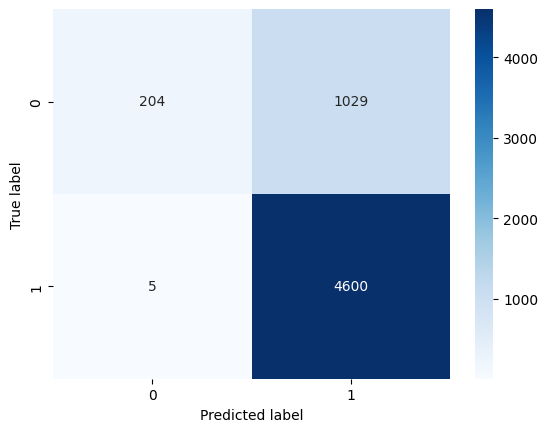

In [14]:
sns.heatmap(sum(conf_matrices), annot=True, cmap="Blues", fmt="d")
plt.xlabel('Predicted label'); plt.ylabel('True label')

Text(50.722222222222214, 0.5, 'True label')

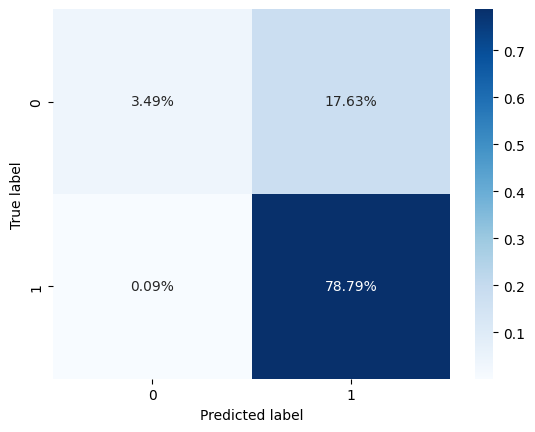

In [15]:
# With percentages instead
sns.heatmap(sum(conf_matrices)/np.sum(sum(conf_matrices)), 
            annot=True, cmap="Blues", fmt=".2%")
plt.xlabel('Predicted label'); plt.ylabel('True label')

In [16]:
# Training on a new 80-20 split to draw ROC curve
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)


model = MechanizedLogisticRegression(max_iter=1500, C=gs_LR.best_params_['C'])
model.choose_mechanism(Mechanism.GAUSSIAN)



model.fit(X_train, y_train)

in gaussian mechanism MechanizedLogisticRegression


MechanizedLogisticRegression(C=5.011872336272722, max_iter=1500)

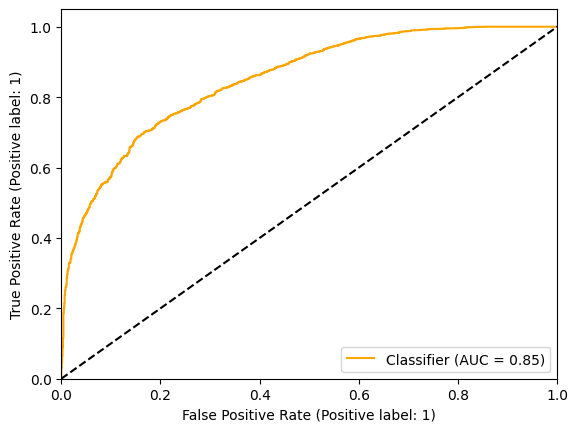

In [17]:
# Display ROC curve
RocCurveDisplay.from_predictions(y_val, model.predict_proba(X_val)[:, 1], color='orange')
plt.xlim([0, 1]); plt.ylim([0, 1.05])
plt.plot([0, 1], [0, 1], 'k--')

# Processing the data - II

In [18]:
# Preprocessing of training data
proc_training_df = apply_cutoff(preprocess(training_df), 2)

# Set cutoff to be the label; define X and y accordingly
X = proc_training_df.drop('cutoff', axis=1)
y = proc_training_df['cutoff']

# Fit TF-IDF vectorizer for 'reviewText' and 'summary' features, creating max. 11500 features.
r_vectorizer = TfidfVectorizer(max_features=11500, stop_words='english', ngram_range=(1, 3))
s_vectorizer = TfidfVectorizer(max_features=11500, stop_words='english', ngram_range=(1, 3))
r_vectorizer.fit(X.reviewText)
s_vectorizer.fit(X.summary)

# Apply TF-IDF vectorization 
X = apply_tfidf(X, r_vectorizer, s_vectorizer)

# Apply robust scaling
scaler = preprocessing.RobustScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# Let us reduce the number of features by eliminating the statistically least correlated ones.
relcols = X.columns[abs(X.corrwith(y)) > 0.01]
X = X[relcols]

# 5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
splits = []
for train_idx, val_idx in kf.split(X, y):
    # Apply split
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Reset indices
    X_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    X_val.reset_index(drop=True, inplace=True)
    y_val.reset_index(drop=True, inplace=True)
    splits.append((X_train, X_val, y_train, y_val))
f1_scores, acc_scores, roc_auc_scores, conf_matrices, models = [], [], [], [], []

## Logistic Regression

In [ ]:
# Hyperparameter selection on one split
X_train, X_val, y_train, y_val = splits[0]
gs_cls = LogisticRegression(max_iter=1500)
params_LR = {'C': np.logspace(0.7, 1.1, num=7)}
gs_LR = GridSearchCV(estimator=gs_cls, param_grid=params_LR, cv=3, verbose=3, scoring='f1_macro')
gs_LR.fit(X_train, y_train)
gs_LR.best_params_

## Mechanized Logistic Regression

In [19]:
# Hyperparameter selection on one split
X_train, X_val, y_train, y_val = splits[0]


gs_cls = MechanizedLogisticRegression(max_iter=1500)
gs_cls.choose_mechanism(Mechanism.GAUSSIAN)


params_LR = {'C': np.logspace(0.7, 1.1, num=1)}
gs_LR = MechanizedGridSearchCV(estimator=gs_cls, param_grid=params_LR, cv=2, verbose=3, scoring='f1_macro')
gs_LR.choose_mechanism(Mechanism.GAUSSIAN)


gs_LR.fit(X_train, y_train)
gs_LR.best_params_

in gaussian mechanism GridSearchCV
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2] END ...............C=5.011872336272722;, score=0.559 total time=   7.0s
[CV 2/2] END ...............C=5.011872336272722;, score=0.570 total time=   7.7s


{'C': 5.011872336272722}

In [20]:
# Let us now compute performance metrics.
for i, (X_train, X_val, y_train, y_val) in enumerate(splits[0:1]):
    print(f"Split {i}:")
    # Train model
    
    # model = LogisticRegression(max_iter=1500, C=gs_LR.best_params_['C'])

    model = MechanizedLogisticRegression(max_iter=1500, C=gs_LR.best_params_['C'])
    model.choose_mechanism(Mechanism.GAUSSIAN)



    model.fit(X_train, y_train)
    # Predict
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)
    # Compute and append f1, accuracy, confusion matrix; 
    f1_scores.append(f1_score(y_val, y_pred, average='macro'))
    acc_scores.append(accuracy_score(y_val, y_pred))
    roc_auc_scores.append(roc_auc_score(y_val, y_proba[:, 1]))
    print(f"  F1 score: {f1_scores[-1]}")
    print(f"  Accuracy: {acc_scores[-1]}")
    print(f"  ROC/AUC score: {roc_auc_scores[-1]}")
    conf_matrices.append(confusion_matrix(y_val, y_pred))
    models.append(model)
print(f"Average F1 score: {np.average(f1_scores)}")
print(f"Average accuracy: {np.average(acc_scores)}")
print(f"Average ROC/AUC score: {np.average(roc_auc_scores)}")

Split 0:
in gaussian mechanism MechanizedLogisticRegression
  F1 score: 0.6781461190110998
  Accuracy: 0.7201096265844468
  ROC/AUC score: 0.8130353389460994
Average F1 score: 0.6781461190110998
Average accuracy: 0.7201096265844468
Average ROC/AUC score: 0.8130353389460994


Text(50.722222222222214, 0.5, 'True label')

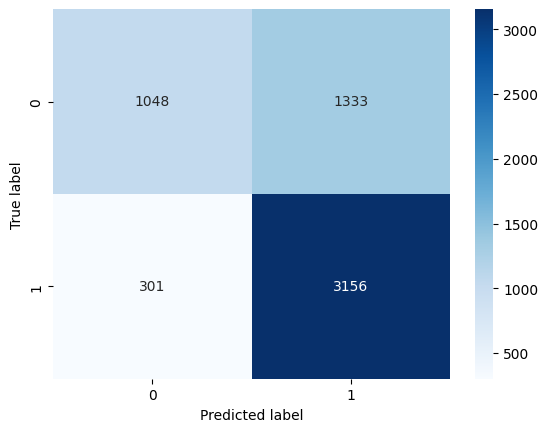

In [21]:
sns.heatmap(sum(conf_matrices), annot=True, cmap="Blues", fmt="d")
plt.xlabel('Predicted label'); plt.ylabel('True label')

Text(50.722222222222214, 0.5, 'True label')

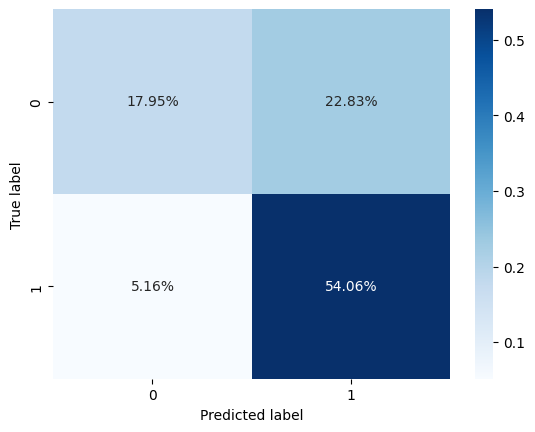

In [22]:
# With percentages instead
sns.heatmap(sum(conf_matrices)/np.sum(sum(conf_matrices)), 
            annot=True, cmap="Blues", fmt=".2%")
plt.xlabel('Predicted label'); plt.ylabel('True label')

In [24]:
# Training on a new 80-20 split to draw ROC curve
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)

model = MechanizedLogisticRegression(max_iter=1500, C=gs_LR.best_params_['C'])
model.choose_mechanism(Mechanism.GAUSSIAN)

model.fit(X_train, y_train)

in gaussian mechanism MechanizedLogisticRegression


MechanizedLogisticRegression(C=5.011872336272722, max_iter=1500)

In [26]:
# Training on a new 80-20 split to draw ROC curve
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)

model = LogisticRegression(max_iter=1500, C=gs_LR.best_params_['C'])

model.fit(X_train, y_train)

LogisticRegression(C=5.011872336272722, max_iter=1500)

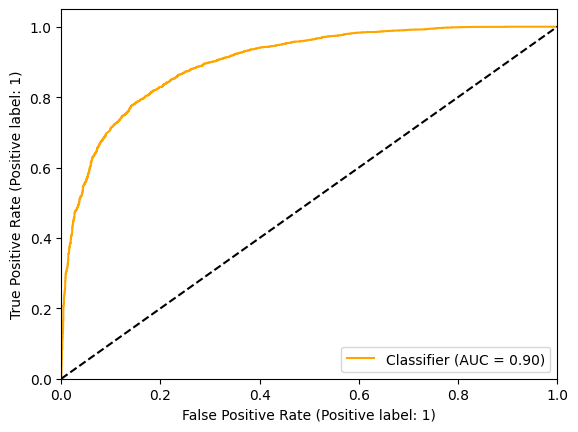

In [27]:
# Display ROC curve
RocCurveDisplay.from_predictions(y_val, model.predict_proba(X_val)[:, 1], color='orange')
plt.xlim([0, 1]); plt.ylim([0, 1.05])
plt.plot([0, 1], [0, 1], 'k--')

# Processing data - III

In [28]:
# Preprocessing of training data
proc_training_df = apply_cutoff(preprocess(training_df), 3)

# Set cutoff to be the label; define X and y accordingly
X = proc_training_df.drop('cutoff', axis=1)
y = proc_training_df['cutoff']

# Fit TF-IDF vectorizer for 'reviewText' and 'summary' features, creating max. 11500 features.
r_vectorizer = TfidfVectorizer(max_features=11500, stop_words='english', ngram_range=(1, 3))
s_vectorizer = TfidfVectorizer(max_features=11500, stop_words='english', ngram_range=(1, 3))
r_vectorizer.fit(X.reviewText)
s_vectorizer.fit(X.summary)

# Apply TF-IDF vectorization 
X = apply_tfidf(X, r_vectorizer, s_vectorizer)

# Apply robust scaling
scaler = preprocessing.RobustScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# Let us reduce the number of features by eliminating the statistically least correlated ones.
relcols = X.columns[abs(X.corrwith(y)) > 0.01]
X = X[relcols]

# 5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
splits = []
for train_idx, val_idx in kf.split(X, y):
    # Apply split
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Reset indices
    X_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    X_val.reset_index(drop=True, inplace=True)
    y_val.reset_index(drop=True, inplace=True)
    splits.append((X_train, X_val, y_train, y_val))
f1_scores, acc_scores, roc_auc_scores, conf_matrices, models = [], [], [], [], []

## Mechanized Logistic Regression

In [29]:
# Hyperparameter selection on one split
X_train, X_val, y_train, y_val = splits[0]
gs_cls = MechanizedLogisticRegression(max_iter=1500)
gs_cls.choose_mechanism(Mechanism.GAUSSIAN)

params_LR = {'C': np.logspace(0.7, 1.1, num=7)}

gs_LR = MechanizedGridSearchCV(estimator=gs_cls, param_grid=params_LR, cv=3, verbose=3, scoring='f1_macro')
gs_LR.choose_mechanism(Mechanism.GAUSSIAN)


gs_LR.fit(X_train, y_train)
gs_LR.best_params_

in gaussian mechanism GridSearchCV
Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV 1/3] END ...............C=5.011872336272722;, score=0.560 total time=  10.7s
[CV 2/3] END ...............C=5.011872336272722;, score=0.563 total time=   9.7s
[CV 3/3] END ...............C=5.011872336272722;, score=0.564 total time=  11.5s
[CV 1/3] END ...............C=5.843414133735175;, score=0.560 total time=   9.6s
[CV 2/3] END ...............C=5.843414133735175;, score=0.563 total time=  10.2s
[CV 3/3] END ...............C=5.843414133735175;, score=0.564 total time=  10.3s
[CV 1/3] END ...............C=6.812920690579613;, score=0.560 total time=  10.0s
[CV 2/3] END ...............C=6.812920690579613;, score=0.563 total time=  10.0s
[CV 3/3] END ...............C=6.812920690579613;, score=0.563 total time=  10.3s
[CV 1/3] END ...............C=7.943282347242816;, score=0.560 total time=  10.9s
[CV 2/3] END ...............C=7.943282347242816;, score=0.563 total time=   9.9s
[CV 3/3] END .

{'C': 5.011872336272722}

In [31]:
# Let us now compute performance metrics.
for i, (X_train, X_val, y_train, y_val) in enumerate(splits[:1]):
    print(f"Split {i}:")
    # Train model
    model = MechanizedLogisticRegression(max_iter=1500, C=gs_LR.best_params_['C'])
    model.choose_mechanism(Mechanism.GAUSSIAN)

    model.fit(X_train, y_train)
    # Predict
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)
    # Compute and append f1, accuracy, confusion matrix; 
    f1_scores.append(f1_score(y_val, y_pred, average='macro'))
    acc_scores.append(accuracy_score(y_val, y_pred))
    roc_auc_scores.append(roc_auc_score(y_val, y_proba[:, 1]))
    print(f"  F1 score: {f1_scores[-1]}")
    print(f"  Accuracy: {acc_scores[-1]}")
    print(f"  ROC/AUC score: {roc_auc_scores[-1]}")
    conf_matrices.append(confusion_matrix(y_val, y_pred))
    models.append(model)
print(f"Average F1 score: {np.average(f1_scores)}")
print(f"Average accuracy: {np.average(acc_scores)}")
print(f"Average ROC/AUC score: {np.average(roc_auc_scores)}")

Split 0:
in gaussian mechanism MechanizedLogisticRegression
  F1 score: 0.47874844163642055
  Accuracy: 0.8107228502911956
  ROC/AUC score: 0.8073215570373108
Average F1 score: 0.47874844163642055
Average accuracy: 0.8107228502911956
Average ROC/AUC score: 0.8073215570373108


Text(50.722222222222214, 0.5, 'True label')

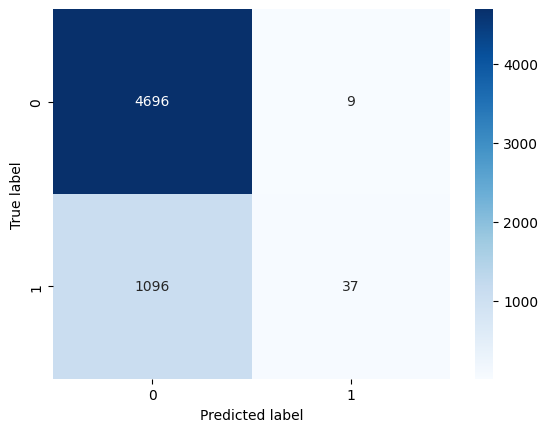

In [32]:
sns.heatmap(sum(conf_matrices), annot=True, cmap="Blues", fmt="d")
plt.xlabel('Predicted label'); plt.ylabel('True label')

Text(50.722222222222214, 0.5, 'True label')

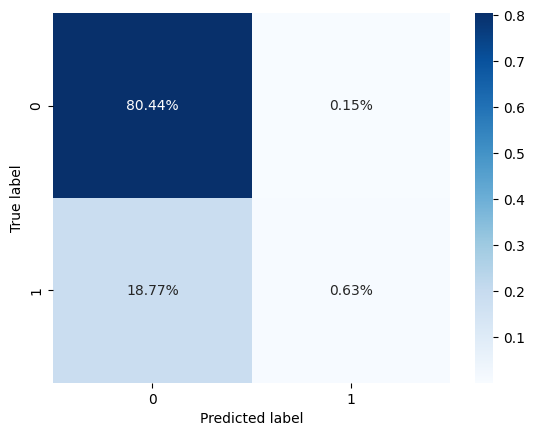

In [33]:
# With percentages instead
sns.heatmap(sum(conf_matrices)/np.sum(sum(conf_matrices)), 
            annot=True, cmap="Blues", fmt=".2%")
plt.xlabel('Predicted label'); plt.ylabel('True label')

In [34]:
# Training on a new 80-20 split to draw ROC curve
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
# model = LogisticRegression(max_iter=1500, C=gs_LR.best_params_['C'])

model = MechanizedLogisticRegression(max_iter=1500, C=gs_LR.best_params_['C'])
model.choose_mechanism(Mechanism.GAUSSIAN)

model.fit(X_train, y_train)

in gaussian mechanism MechanizedLogisticRegression


MechanizedLogisticRegression(C=5.011872336272722, max_iter=1500)

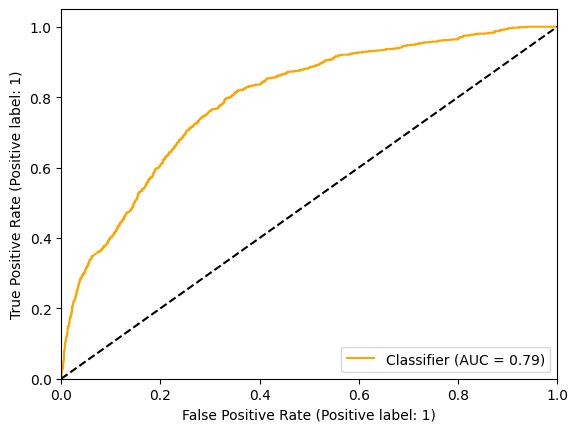

In [35]:
# Display ROC curve
RocCurveDisplay.from_predictions(y_val, model.predict_proba(X_val)[:, 1], color='orange')
plt.xlim([0, 1]); plt.ylim([0, 1.05])
plt.plot([0, 1], [0, 1], 'k--')

# Processing data - IV

In [30]:
# Preprocessing of training data
proc_training_df = apply_cutoff(preprocess(training_df), 4)

# Set cutoff to be the label; define X and y accordingly
X = proc_training_df.drop('cutoff', axis=1)
y = proc_training_df['cutoff']

# Fit TF-IDF vectorizer for 'reviewText' and 'summary' features, creating max. 11500 features.
r_vectorizer = TfidfVectorizer(max_features=11500, stop_words='english', ngram_range=(1, 3))
s_vectorizer = TfidfVectorizer(max_features=11500, stop_words='english', ngram_range=(1, 3))
r_vectorizer.fit(X.reviewText)
s_vectorizer.fit(X.summary)

# Apply TF-IDF vectorization 
X = apply_tfidf(X, r_vectorizer, s_vectorizer)

# Apply robust scaling
scaler = preprocessing.RobustScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# Let us reduce the number of features by eliminating the statistically least correlated ones.
relcols = X.columns[abs(X.corrwith(y)) > 0.01]
X = X[relcols]

# 5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
splits = []
for train_idx, val_idx in kf.split(X, y):
    # Apply split
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Reset indices
    X_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    X_val.reset_index(drop=True, inplace=True)
    y_val.reset_index(drop=True, inplace=True)
    splits.append((X_train, X_val, y_train, y_val))
f1_scores, acc_scores, roc_auc_scores, conf_matrices, models = [], [], [], [], []

## Logistic Regression

In [36]:
# Hyperparameter selection on one split
X_train, X_val, y_train, y_val = splits[0]
gs_cls = MechanizedLogisticRegression(max_iter=1500, C=gs_LR.best_params_['C'])
gs_cls.choose_mechanism(Mechanism.GAUSSIAN)

params_LR = {'C': np.logspace(0.7, 1.1, num=1)}
gs_LR = MechanizedGridSearchCV(estimator=gs_cls, param_grid=params_LR, cv=2, verbose=3, scoring='f1_macro')
gs_LR.choose_mechanism(Mechanism.GAUSSIAN)

gs_LR.fit(X_train, y_train)
gs_LR.best_params_

in gaussian mechanism GridSearchCV
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2] END ...............C=5.011872336272722;, score=0.536 total time=   6.8s
[CV 2/2] END ...............C=5.011872336272722;, score=0.545 total time=   6.5s


{'C': 5.011872336272722}

In [37]:
# Let us now compute performance metrics.
for i, (X_train, X_val, y_train, y_val) in enumerate(splits[:1]):
    print(f"Split {i}:")
    # Train model
    # model = LogisticRegression(max_iter=1500, C=gs_LR.best_params_['C'])

    model = MechanizedLogisticRegression(max_iter=1500, C=gs_LR.best_params_['C'])
    model.choose_mechanism(Mechanism.GAUSSIAN)


    model.fit(X_train, y_train)
    # Predict
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)
    # Compute and append f1, accuracy, confusion matrix; 
    f1_scores.append(f1_score(y_val, y_pred, average='macro'))
    acc_scores.append(accuracy_score(y_val, y_pred))
    roc_auc_scores.append(roc_auc_score(y_val, y_proba[:, 1]))
    print(f"  F1 score: {f1_scores[-1]}")
    print(f"  Accuracy: {acc_scores[-1]}")
    print(f"  ROC/AUC score: {roc_auc_scores[-1]}")
    conf_matrices.append(confusion_matrix(y_val, y_pred))
    models.append(model)
print(f"Average F1 score: {np.average(f1_scores)}")
print(f"Average accuracy: {np.average(acc_scores)}")
print(f"Average ROC/AUC score: {np.average(roc_auc_scores)}")

Split 0:
in gaussian mechanism MechanizedLogisticRegression
  F1 score: 0.471060535743152
  Accuracy: 0.8095238095238095
  ROC/AUC score: 0.8113995833618626
Average F1 score: 0.4749044886897863
Average accuracy: 0.8101233299075026
Average ROC/AUC score: 0.8093605701995867


Text(50.722222222222214, 0.5, 'True label')

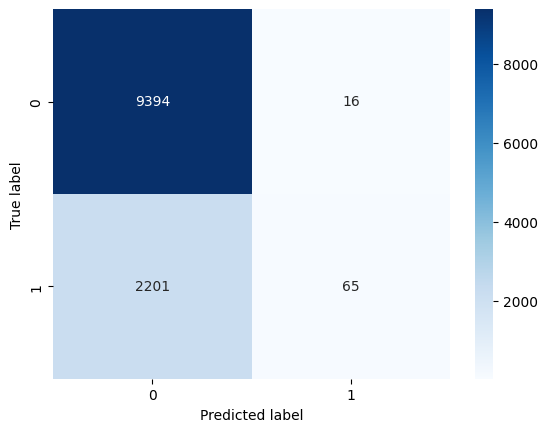

In [38]:
sns.heatmap(sum(conf_matrices), annot=True, cmap="Blues", fmt="d")
plt.xlabel('Predicted label'); plt.ylabel('True label')

Text(50.722222222222214, 0.5, 'True label')

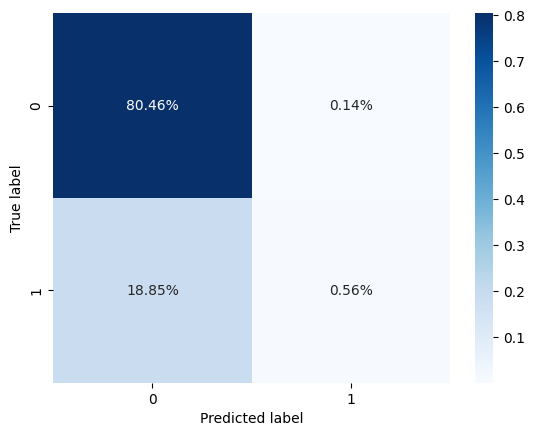

In [39]:
# With percentages instead
sns.heatmap(sum(conf_matrices)/np.sum(sum(conf_matrices)), 
            annot=True, cmap="Blues", fmt=".2%")
plt.xlabel('Predicted label'); plt.ylabel('True label')

In [40]:
# Training on a new 80-20 split to draw ROC curve
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)

model = MechanizedLogisticRegression(max_iter=1500, C=gs_LR.best_params_['C'])
model.choose_mechanism(Mechanism.GAUSSIAN)

model.fit(X_train, y_train)

in gaussian mechanism MechanizedLogisticRegression


MechanizedLogisticRegression(C=5.011872336272722, max_iter=1500)

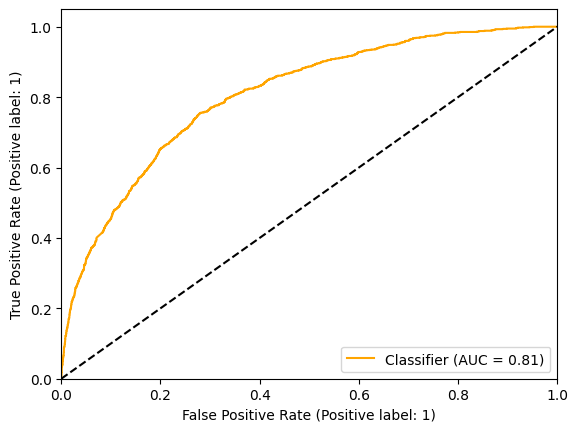

In [41]:
# Display ROC curve
RocCurveDisplay.from_predictions(y_val, model.predict_proba(X_val)[:, 1], color='orange')
plt.xlim([0, 1]); plt.ylim([0, 1.05])
plt.plot([0, 1], [0, 1], 'k--')